In [4]:
import torchvision
import torch

# Load Data

In [602]:
from torch.utils.data import DataLoader, Subset

# get 10,000 length dataset subset 
dataset = torchvision.datasets.CIFAR10(root="cifar", train=True, download=True, transform=torchvision.transforms.ToTensor())
subset_length = 10000
train_loader = DataLoader(dataset, batch_size=32)
dataset_mini = Subset(dataset, range(subset_length))
trainloader_mini = DataLoader(dataset_mini, batch_size=32)

Files already downloaded and verified


In [603]:
# biased dataset, need to implement short circuiting prevention in order to use 

# Define the desired total number of samples
total_samples = subset_length

# Define the percentages for each class
percentage_from_class = {
    0: 0.4,
    1: 0.2,
    # Remaining classes will get an equal share
}

# Calculate the remaining percentage for classes 2-9
remaining_percentage = 1.0 - sum(percentage_from_class.values())

# Distribute the remaining percentage evenly among classes 2-9
remaining_percentage_per_class = remaining_percentage / (10 - len(percentage_from_class))

# Calculate the number of samples to take from each class
subset_indices = []

for class_label, percentage in percentage_from_class.items():
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    num_samples_class = int(total_samples * percentage)
    subset_indices.extend(class_indices[:num_samples_class])

# Distribute the remaining samples to classes 2-9
for class_label in range(2, 10):
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    num_samples_class = int(total_samples * remaining_percentage_per_class)
    subset_indices.extend(class_indices[:num_samples_class])

# Ensure the total number of samples is exactly 10,000
subset_indices = subset_indices[:total_samples]

# Create the Subset with the specified indices
dataset_mini_biased = Subset(dataset, subset_indices)

# Create DataLoader
trainloader_mini_biased = DataLoader(dataset_mini_biased, batch_size=32)

In [351]:
# get mapping of label ints to label names 
import pickle

batches_meta_file_path = 'cifar/cifar-10-batches-py/batches.meta'

with open(batches_meta_file_path, 'rb') as f:
    batches_meta_data = pickle.load(f)

label_names = batches_meta_data.get('label_names', None)

for i in range(len(label_names)):
    print(str(i) + ': ' +label_names[i])

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


In [604]:
# Count datapoints per class
class_counts = {i: 0 for i in range(10)}  

for data in trainloader_mini_biased:
    _, labels = data
    for label in labels:
        class_counts[label.item()] += 1

# Print the counts
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} datapoints")

Class 0: 4000 datapoints
Class 1: 2000 datapoints
Class 2: 499 datapoints
Class 3: 499 datapoints
Class 4: 499 datapoints
Class 5: 499 datapoints
Class 6: 499 datapoints
Class 7: 499 datapoints
Class 8: 499 datapoints
Class 9: 499 datapoints


# Non Differentially Private Model

In [610]:
# resnet model, adjusted for 32x32 CIFAR images images
model = torchvision.models.resnet18()

model.avgpool = torch.nn.AdaptiveAvgPool2d(1)

n_features = model.fc.in_features
n_classes = 10
model.fc = torch.nn.Linear(n_features, n_classes)

# Accuracy before training

In [356]:
import torch
from sklearn.metrics import confusion_matrix

# Ensure model in training mode
model.train()

# Initialize variables
correct_predictions = 0
total_samples = 0
class_correct = [0] * n_classes  
class_total = [0] * n_classes

# Evaluate the model on the entire dataset
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update per-class statistics
        for i in range(n_classes):
            class_correct[i] += ((predicted == labels) & (labels == i)).sum().item()
            class_total[i] += (labels == i).sum().item()

# Calculate overall accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

# Calculate accuracy per label
for i in range(n_classes):
    class_acc = class_correct[i] / class_total[i] if class_total[i] != 0 else 0
    print(f"Accuracy for label {label_names[i]}: {class_acc * 100:.2f}%")


Accuracy on the training set: 9.44%
Accuracy for label airplane: 4.26%
Accuracy for label automobile: 0.04%
Accuracy for label bird: 15.18%
Accuracy for label cat: 3.72%
Accuracy for label deer: 39.08%
Accuracy for label dog: 0.04%
Accuracy for label frog: 1.92%
Accuracy for label horse: 23.36%
Accuracy for label ship: 5.06%
Accuracy for label truck: 1.76%


In [357]:
# save untrained model 
torch.save(model.state_dict(), 'model_untrained_1.pt')


# Training Non Differentially Private Model

In [611]:
# training 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch():
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(trainloader_mini):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10  # loss per batch
            print(f"batch {i+1} loss: {last_loss}")
            running_loss = 0.0

In [612]:
EPOCHS = 5
for i in range(EPOCHS):
    print(f"Epoch: {i+1}")
    train_one_epoch()

Epoch: 1
batch 10 loss: 0.770458270329982
batch 20 loss: 0.001341010733449366
batch 30 loss: 8.196803973987698e-05
batch 40 loss: 3.87634940125281e-05
batch 50 loss: 3.3866098056023476e-05
batch 60 loss: 2.212325816799421e-05
batch 70 loss: 2.179072344006272e-05
batch 80 loss: 2.217123455920955e-05
batch 90 loss: 2.4013922666199505e-05
batch 100 loss: 2.6201683067483827e-05
batch 110 loss: 2.147280783901806e-05
batch 120 loss: 2.7335498998581897e-05
batch 130 loss: 5.890845071939839
batch 140 loss: 0.7714707814000576
batch 150 loss: 1.5679627509257444e-06
batch 160 loss: 7.63683996041209e-08
batch 170 loss: 1.415609804933382e-08
batch 180 loss: 2.458690602225033e-08
batch 190 loss: 5.595492754876607
batch 200 loss: 8.370921320654451
batch 210 loss: 10.264572607411537
batch 220 loss: 3.7014779657125474
batch 230 loss: 8.558609676361083
batch 240 loss: 5.457883715629578
batch 250 loss: 3.901036334037781
batch 260 loss: 5.847078609466553
batch 270 loss: 3.7020266890525817
batch 280 loss: 

# Model Accuracy

In [608]:
import torch
from sklearn.metrics import confusion_matrix
def calc_accuracy(model):
    # Ensure model in eval mode
    model.eval()
    
    # Initialize variables
    correct_predictions = 0
    total_samples = 0
    class_correct = [0] * n_classes  
    class_total = [0] * n_classes
    
    # Evaluate the model on the entire dataset
    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
            # Update per-class statistics
            for i in range(n_classes):
                class_correct[i] += ((predicted == labels) & (labels == i)).sum().item()
                class_total[i] += (labels == i).sum().item()
    
    # Calculate overall accuracy
    accuracy = correct_predictions / total_samples
    print(f"Accuracy on the training set: {accuracy * 100:.2f}%")
    
    # Calculate accuracy per label
    for i in range(n_classes):
        class_acc = class_correct[i] / class_total[i] if class_total[i] != 0 else 0
        print(f"Accuracy for label {label_names[i]}: {class_acc * 100:.2f}%")



In [613]:
calc_accuracy(model)

Accuracy on the training set: 9.64%
Accuracy for label airplane: 0.00%
Accuracy for label automobile: 0.00%
Accuracy for label bird: 0.00%
Accuracy for label cat: 0.00%
Accuracy for label deer: 0.00%
Accuracy for label dog: 0.00%
Accuracy for label frog: 0.00%
Accuracy for label horse: 0.00%
Accuracy for label ship: 93.34%
Accuracy for label truck: 3.02%


In [732]:
import torch

# function which takes in a model and outputs two dictionaries which store 
# which datapoints model predicted correctly and incorrectly 
def create_predictions_dictionaries(model):
    correct_predictions_dict = {label: [] for label in range(10)}
    incorrect_predictions_dict = {label: [] for label in range(10)}

    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(train_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for j in range(len(predicted)):
                label = int(targets[j])
                if predicted[j] == targets[j]:
                    correct_predictions_dict[label].append(i * train_loader.batch_size + j)
                else:
                    incorrect_predictions_dict[label].append(i * train_loader.batch_size + j)

    return correct_predictions_dict, incorrect_predictions_dict


In [614]:
torch.save(model.state_dict(), 'model_trained_biased_1.pt')


# Displaying a Sigular Model Prediction

In [418]:
import matplotlib.pyplot as plt
import numpy as np

32161


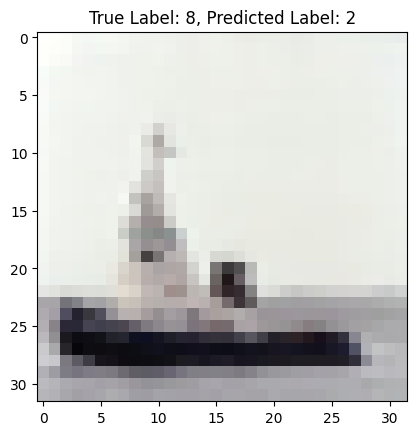

In [883]:
# set a random seet
np.random.seed(38) 

# Choose a random index from the training set
random_index = np.random.randint(len(dataset))

print(random_index)
# Get the corresponding image and label
random_image, true_label = dataset[47373]

# Add a batch dimension to the image
random_image = random_image.unsqueeze(0)

# set back to eval mode
model3b.eval()

# Make a prediction for the random image
with torch.no_grad():
    predicted_scores = model1b(random_image)

# Get the predicted label
predicted_label = torch.argmax(predicted_scores).item()

# Display the image
random_image_np = random_image.squeeze().numpy()

plt.imshow(np.transpose(random_image_np, (1, 2, 0)))
plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
plt.show()


# Create Segmentation

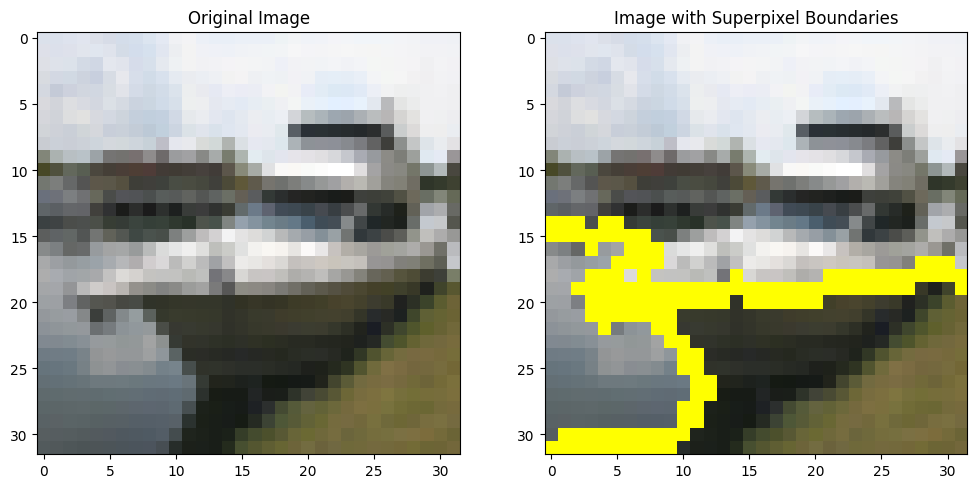

In [855]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color
from skimage.io import imshow


# takes in np image of C X H X W
# returns image where boundaries are superimposed, H X W X C

def create_segmentation(image_np):
    # Higher value of compactness give more weight to space proximity,
    # making superpixel shapes more square/cubic. should choose values on log scale
    # i.e. .01, .1, 10, 100...
    segments = segmentation.slic(image_np, n_segments=5, compactness=.01, channel_axis=0)
    masked_image =  segmentation.mark_boundaries(np.transpose(image_np, (1, 2, 0)), segments)

    return masked_image

    
def create_fm(image_np):

    segments = segmentation.slic(image_np, n_segments=5, compactness=.01, channel_axis=0)
    feature_map = np.zeros_like(image_np[0])  # Assuming image_np is in the shape (C, H, W)
    
    for segment_value in np.unique(segments):
        mask = segments == segment_value
        feature_map[mask] = segment_value

    return feature_map


create_fm(random_image_np)
# Display the original image 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(random_image_np, (1, 2, 0)))
plt.title('Original Image')

# Display the image with superpixel boundaries
plt.subplot(1, 2, 2)
seg = create_segmentation(random_image_np)
plt.imshow(seg)
plt.title('Image with Superpixel Boundaries')
plt.show()



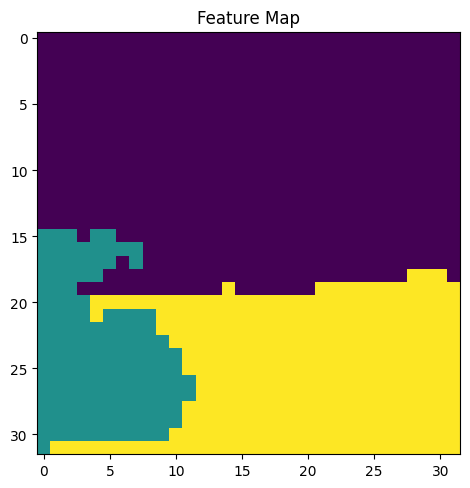

In [856]:

# Display the image with superpixel boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fm = create_fm(random_image_np)
plt.imshow(fm)
plt.title('Feature Map')
plt.show()


# Lime Explanation Function 

In [516]:
import torch
from captum.attr import LayerIntegratedGradients, LayerGradientXActivation
from captum.attr import visualization as viz
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
import os
import json

In [517]:
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [518]:
# create segmentation mask
tensimg = torch.tensor(random_image_np)
seg_mask = torch.tensor(create_segmentation(random_image_np))



In [519]:
# output probabilities of image being classified as 
# top 'k' categories, with highest probability signifying 
# the final classification  

def create_li(model, img_tens): 
    outputs = model(img_tens.unsqueeze(0))
    output_probs = F.softmax(outputs, dim=1).squeeze(0)
    return output_probs.argmax().unsqueeze(0)

def probs_of_image(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = label_names[idx]
        print(f'{label} ({idx}):', round(prob, 4))
        
probs_of_image(output_probs, topk=5)

airplane (0): 0.7259
deer (4): 0.1318
frog (6): 0.0758
truck (9): 0.0285
bird (2): 0.0207







Lime attribution: 100%|███████████████████████████| 3/3 [00:00<00:00,  6.71it/s]


Attribution range: 0.16320689022541046 to 0.31571778655052185


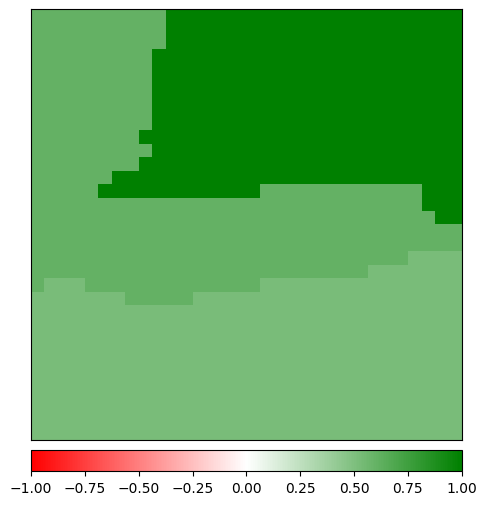

In [536]:
# take in model and random image in np array
# output lime image explanation heatmap 
def create_limeimageexp(model, image_np):
    image_tens = torch.tensor(image_np)
    seg_mask = torch.tensor(create_segmentation(image_np))

    outputs = model(image_tens.unsqueeze(0))
    output_probs = F.softmax(outputs, dim=1).squeeze(0)
    label_idx = output_probs.argmax().unsqueeze(0)

    seg_ids = sorted(seg_mask.unique().tolist())

    # map segment IDs to feature group IDs
    feature_mask = seg_mask.clone()
    for i, seg_id in enumerate(seg_ids):
        feature_mask[feature_mask == seg_id] = i

    feature_mask = torch.tensor(create_fm(image_np), dtype=torch.long)
    for i, seg_id in enumerate(seg_ids):
        feature_mask[feature_mask == seg_id] = i
    
    exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

    lr_lime = Lime(
        model, 
        interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
        similarity_func=exp_eucl_distance
    )

    attrs = lr_lime.attribute(
        image_tens.unsqueeze(0),
        target=label_idx,
        feature_mask=feature_mask,
        n_samples=40,
        perturbations_per_eval=16,
        show_progress=True
    ).squeeze(0)
    
    print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())


    viz.visualize_image_attr(
        attrs.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels
        method='heat_map',
        sign='all',
        show_colorbar=True
    )




# Differential privacy

In [835]:
import warnings
warnings.simplefilter("ignore")

MAX_GRAD_NORM = .1
# higher epsilon = higher privact budget = less private model 
EPSILON = .1
DELTA = .0001
EPOCHS = 5

LR = 1e-3

# Fine Tuning 

In [838]:


import copy

# make a copy of non dp model 
# for which we will fine tune last layers with dp 
model_dp = copy.deepcopy(model2)

# Create backbone and head
backbone_dp = torch.nn.Sequential(*list(model_dp.children())[:-1])
head_dp = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(n_features, n_classes))

# Set the backbone to evaluation mode
backbone_dp = backbone_dp.eval()

# Set the head to training mode
head_dp = head_dp.train()



In [839]:
x, y = next(iter(trainloader_mini_biased))

with torch.no_grad():
  representation = backbone_dp(x)

# quick sanity check
head_dp(representation).shape



torch.Size([28, 10])

In [840]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(head_dp, strict=False)
errors[-5:]

[]

In [841]:
head_dp = ModuleValidator.fix(head_dp)
ModuleValidator.validate(head_dp, strict=False)

[]

In [842]:
# training  

loss_fn_dp = torch.nn.CrossEntropyLoss()
optimizer_dp = torch.optim.SGD(head_dp.parameters(), lr=0.001, momentum=0.9)

In [845]:
# mini dataset privacy engine
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

head_dp, optimizer_dp, trainloader_mini = privacy_engine.make_private_with_epsilon(
    module=head_dp,
    optimizer=optimizer_dp,
    data_loader=trainloader_mini,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer_dp.noise_multiplier} and C={MAX_GRAD_NORM}")

Using sigma=3.75 and C=0.1


In [846]:

def train_one_epoch_dp():
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(trainloader_mini):
        
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer_dp.zero_grad()

        # Extract features from the backbone
        with torch.no_grad():
            features = backbone_dp(inputs)

        # Make predictions for this batch using the extracted features
        outputs = head_dp(features)

        # Compute the loss and its gradients
        loss = loss_fn_dp(outputs, labels)

        running_loss += loss.item()
        loss.backward()

        # Adjust learning weights only for head parameters
        optimizer_dp.step()

        # Gather data and report
        if i % 10 == 9:
            epsilon = privacy_engine.get_epsilon(DELTA)
            last_loss = running_loss / 10  # loss per batch
            print(f"batch {i+1} loss: {last_loss}")
            print(f"(ε = {epsilon:.2f}, δ = {DELTA})")
            running_loss = 0.0


In [847]:
for i in range(EPOCHS):
    print(f"Epoch: {1+i}")
    train_one_epoch_dp()

Epoch: 1
batch 10 loss: 2.868224596977234
(ε = 0.01, δ = 0.0001)
batch 20 loss: 2.857881855964661
(ε = 0.02, δ = 0.0001)
batch 30 loss: 2.8479529857635497
(ε = 0.02, δ = 0.0001)
batch 40 loss: 2.820332384109497
(ε = 0.02, δ = 0.0001)
batch 50 loss: 2.8118637084960936
(ε = 0.02, δ = 0.0001)
batch 60 loss: 2.7292364835739136
(ε = 0.02, δ = 0.0001)
batch 70 loss: 2.6890204191207885
(ε = 0.02, δ = 0.0001)
batch 80 loss: 2.6564183235168457
(ε = 0.02, δ = 0.0001)
batch 90 loss: 2.7111972093582155
(ε = 0.03, δ = 0.0001)
batch 100 loss: 2.6722443103790283
(ε = 0.03, δ = 0.0001)
batch 110 loss: 2.642640805244446
(ε = 0.03, δ = 0.0001)
batch 120 loss: 2.657654595375061
(ε = 0.03, δ = 0.0001)
batch 130 loss: 2.621382808685303
(ε = 0.03, δ = 0.0001)
batch 140 loss: 2.5085468530654906
(ε = 0.03, δ = 0.0001)
batch 150 loss: 2.5833354711532595
(ε = 0.03, δ = 0.0001)
batch 160 loss: 2.576019358634949
(ε = 0.03, δ = 0.0001)
batch 170 loss: 2.474162483215332
(ε = 0.03, δ = 0.0001)
batch 180 loss: 2.4093

# DP Model Accuracy

In [834]:
print(type(backbone_dp))

<class 'torch.nn.modules.container.Sequential'>


In [848]:
# make sure to modify code to whatever version of model u are testing accuracy for

import torch
from sklearn.metrics import confusion_matrix

# Ensure model in training mode
backbone_dp.train()
head_dp.train()

# Initialize variables
correct_predictions = 0
total_samples = 0
class_correct = [0] * n_classes  
class_total = [0] * n_classes

# Evaluate the model on the entire dataset
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        features = backbone_dp(images)
        outputs = head_dp(features)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update per-class statistics
        for i in range(n_classes):
            class_correct[i] += ((predicted == labels) & (labels == i)).sum().item()
            class_total[i] += (labels == i).sum().item()

# Calculate overall accuracy
accuracy = correct_predictions / total_samples
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

# Calculate accuracy per label
for i in range(n_classes):
    class_acc = class_correct[i] / class_total[i] if class_total[i] != 0 else 0
    print(f"Accuracy for label {label_names[i]}: {class_acc * 100:.2f}%")
total_samples
print(f"Accuracy on the training set: {accuracy * 100:.2f}%")

Accuracy on the training set: 12.68%
Accuracy for label airplane: 97.82%
Accuracy for label automobile: 28.92%
Accuracy for label bird: 0.00%
Accuracy for label cat: 0.00%
Accuracy for label deer: 0.00%
Accuracy for label dog: 0.02%
Accuracy for label frog: 0.00%
Accuracy for label horse: 0.02%
Accuracy for label ship: 0.00%
Accuracy for label truck: 0.02%
Accuracy on the training set: 12.68%


In [648]:
torch.save(head_dp.state_dict(), '3_head_unbiased.pt')
torch.save(backbone_dp.state_dict(), '3_backbone_unbiased.pt')

# Load trained models!

In [493]:
# load 5 models 

model1 = torchvision.models.resnet18()
model1.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model1.fc.in_features
n_classes = 10
model1.fc = torch.nn.Linear(n_features, n_classes)
model1_dict = torch.load('model_untrained_1.pt')
model1.load_state_dict(model1_dict)
model1.eval()



model2 = torchvision.models.resnet18()
model2.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model2.fc.in_features
n_classes = 10
model2.fc = torch.nn.Linear(n_features, n_classes)
model2_dict = torch.load('model_trained_1.pt')
model2.load_state_dict(model2_dict)
model2.eval()

model3 = torchvision.models.resnet18()
model3.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model3.fc.in_features
n_classes = 10
model3.fc = torch.nn.Linear(n_features, n_classes)
model3_dict = torch.load('model_dp_eps_point1_1.pt')
model3.load_state_dict(model3_dict)
model3.eval()


model4 = torchvision.models.resnet18()
model4.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model4.fc.in_features
n_classes = 10
model4.fc = torch.nn.Linear(n_features, n_classes)
model4_dict = torch.load('model_dp_eps_5_1.pt')
model4.load_state_dict(model4_dict)
model4.eval()


model5 = torchvision.models.resnet18()
model5.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model5.fc.in_features
n_classes = 10
model5.fc = torch.nn.Linear(n_features, n_classes)
model5_dict = torch.load('model_dp_eps_25_1.pt')
model5.load_state_dict(model5_dict)
model5.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [673]:
# load biased models (work in progress)

model1b = torchvision.models.resnet18()
model1b.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model1b.fc.in_features
n_classes = 10
model1b.fc = torch.nn.Linear(n_features, n_classes)
model1b_dict = torch.load('model_untrained_1.pt')
model1b.load_state_dict(model1b_dict)
model1b.eval()



model2b = torchvision.models.resnet18()
model2b.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model2b.fc.in_features
n_classes = 10
model2b.fc = torch.nn.Linear(n_features, n_classes)
model2b_dict = torch.load('model_trained_biased_1.pt')
model2b.load_state_dict(model2b_dict)
model2b.eval()

model3b = torchvision.models.resnet18()
model3b.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model3b.fc.in_features
n_classes = 10
model3b.fc = torch.nn.Linear(n_features, n_classes)
model3b_dict = torch.load('model_dp_eps_point1_biased_1.pt')
model3b.load_state_dict(model3b_dict)
model3b.eval()


model4b = torchvision.models.resnet18()
model4b.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model4b.fc.in_features
n_classes = 10
model4b.fc = torch.nn.Linear(n_features, n_classes)
model4b_dict = torch.load('model_dp_eps_5_biased_1.pt')
model4b.load_state_dict(model4b_dict)
model4b.eval()


model5b = torchvision.models.resnet18()
model5b.avgpool = torch.nn.AdaptiveAvgPool2d(1)
n_features = model5b.fc.in_features
n_classes = 10
model5b.fc = torch.nn.Linear(n_features, n_classes)
model5b_dict = torch.load('model_dp_eps_25_biased_1.pt')
model5b.load_state_dict(model5b_dict)
model5b.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Lime attribution: 100%|███████████████████████████| 3/3 [00:00<00:00,  8.57it/s]


Attribution range: -0.8874900341033936 to 0.6057196855545044


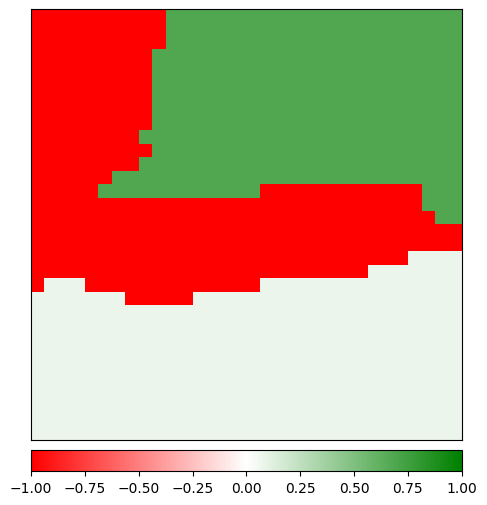

In [574]:
# rerun this code based on image you wish to generate explanation for
# use prediction dictionaries to find out which image you want to generate explanation for 
# i.e. dataset[32161] corresponds to an image which was predicted correctly with the non-private model
# and incorrectly for the private model
cor_incor, label = dataset[32161] 
cor_incor = cor_incor.squeeze().numpy()
create_limeimageexp(model5, cor_incor)




# Prediction Dictionary work 
### By evaluating and comparing dictionaries, you can figure out which images are relevant for analysis

In [831]:
# 'b' correlated to biased models which is still a work in progress 
model1b_cor_pred_dict, model1b_incor_pred_dict = create_predictions_dictionaries(model1b)
model2b_cor_pred_dict, model2b_incor_pred_dict = create_predictions_dictionaries(model2b)
model3b_cor_pred_dict, model3b_incor_pred_dict = create_predictions_dictionaries(model3b)
model4b_cor_pred_dict, model4b_incor_pred_dict = create_predictions_dictionaries(model4b)
model5b_cor_pred_dict, model5b_incor_pred_dict = create_predictions_dictionaries(model5b)

In [734]:
model1_cor_pred_dict, model1_incor_pred_dict = create_predictions_dictionaries(model1)
model2_cor_pred_dict, model2_incor_pred_dict = create_predictions_dictionaries(model2)
model3_cor_pred_dict, model3_incor_pred_dict = create_predictions_dictionaries(model3)
model4_cor_pred_dict, model4_incor_pred_dict = create_predictions_dictionaries(model4)
model5_cor_pred_dict, model5_incor_pred_dict = create_predictions_dictionaries(model5)

In [662]:
listcor = []
listcor.append((model1_pred_dict[1])
               
print(model1_pred_dict[1])


[4945, 5014, 39132, 46279, 48036]


In [798]:
sharedIncorrectPredsDict = {}
for i in range(n_classes):
    sharedIncorrectPredsDict[i] = set(model1_incor_pred_dict[i]).intersection(model2_incor_pred_dict[i], model3_incor_pred_dict[i], model4_incor_pred_dict[i], model5_incor_pred_dict[i])

In [799]:
sharedCorrectPredsDict = {}
for i in range(n_classes):
    sharedCorrectPredsDict[i] = set(model1_pred_dict[i]).intersection(model2_pred_dict[i], model3_pred_dict[i], model4_pred_dict[i], model5_pred_dict[i])

sharedCorrectPredsDict

In [863]:
sharedCorrectPredsDict_b = {}
for i in range(n_classes):
    sharedCorrectPredsDict_b[i] = set(model1b_cor_pred_dict[i]).intersection(model2b_cor_pred_dict[i], model3b_cor_pred_dict[i], model4b_cor_pred_dict[i], model5b_cor_pred_dict[i])

287

In [867]:
sharedIncorrectPredsDict_b = {}
for i in range(n_classes):
    sharedIncorrectPredsDict_b[i] = set(model1b_incor_pred_dict[i]).intersection(model2b_incor_pred_dict[i], model3b_incor_pred_dict[i], model4b_incor_pred_dict[i], model5b_incor_pred_dict[i])

sharedIncorrectPredsDict_b[8]

{290,
 741,
 1183,
 1749,
 2176,
 2388,
 2462,
 2489,
 2577,
 3240,
 3258,
 3425,
 4001,
 4300,
 4718,
 4892,
 5030,
 5304,
 5377,
 5378,
 5675,
 5891,
 6139,
 6322,
 6337,
 6565,
 6717,
 6909,
 7237,
 7281,
 8668,
 9262,
 10268,
 10511,
 10613,
 10638,
 10646,
 11352,
 11593,
 12126,
 12236,
 12268,
 12457,
 13095,
 13109,
 13266,
 13476,
 13616,
 13982,
 14624,
 14693,
 14821,
 15727,
 15951,
 16259,
 16315,
 16435,
 16479,
 16572,
 17010,
 17330,
 17482,
 17516,
 17592,
 17696,
 17962,
 18153,
 18232,
 18307,
 18700,
 18728,
 19195,
 19336,
 19530,
 19648,
 19658,
 19829,
 19836,
 20089,
 20395,
 20620,
 20863,
 20889,
 20898,
 20949,
 21111,
 21257,
 21880,
 21936,
 22096,
 23681,
 23872,
 24164,
 24315,
 24386,
 24740,
 24765,
 25123,
 25412,
 26603,
 26967,
 27783,
 27808,
 28153,
 28682,
 29056,
 29078,
 29239,
 29524,
 29726,
 29991,
 30329,
 30488,
 30997,
 31456,
 31526,
 31563,
 31565,
 31608,
 31697,
 32051,
 32132,
 33695,
 34468,
 34522,
 34636,
 34792,
 35586,
 35985,
 3

In [ ]:
# find a sample which gets incorrectly predicted by dp but correctly predicted by non dp and low priv

noisedOutSamplesDict = {}
for i in range (n_classes):
    # list of images which were predicted correctly by non private and incorrectly by high 
    # privacy model
    combined =  [element for element in (model2_cor_pred_dict[i]).intersection(model3_incor_pred_dict[i])

In [730]:
# quick check , should be 0 
print(len(set(sharedIncorrectPredsDict[0].intersection(sharedCorrectPredsDict[0]))))

0


# Spare Code

In [ ]:
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root="cifar", train=True, download=True, transform=transform)

# Define the percentages for each class
percentage_from_class = {
    0: 0.4,
    1: 0.2,
    # Remaining classes will get an equal share
}

subset_indices = []

# Iterate over each class
for class_label, percentage in percentage_from_class.items():
    # Find the indices corresponding to the current class
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    
    # Calculate the number of samples to take from the current class
    num_samples_class = int(len(class_indices) * percentage)
    
    # Take the specified percentage from the current class
    subset_indices.extend(class_indices[:num_samples_class])

# Create the Subset with the specified indices
dataset_mini = Subset(dataset, subset_indices)

# Create DataLoader
trainloader_mini = DataLoader(dataset_mini, batch_size=32, shuffle=True)

# Now, trainloader_mini contains the desired distribution of data from different classes


In [ ]:
# #### Non Fine Tuning #############
# resnet model, adjusted for 32x32 CIFAR images images
model_dp = torchvision.models.resnet18(pretrained=True)

# how does pooling not strip all the information from the image
model_dp.avgpool = torch.nn.AdaptiveAvgPool2d(1)
# what is a "feature" in supervised learning, is it just edges, shapes, etc. 
# how does feature identification differ from identifying clusters in unsupervised learning 
n_features = model_dp.fc.in_features
n_classes = 10
model_dp.fc = torch.nn.Linear(n_features, n_classes)

from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(model_dp, strict=False)
errors[-5:]

model_dp = ModuleValidator.fix(model_dp)
ModuleValidator.validate(model_dp, strict=False)

# training  

loss_fn_dp = torch.nn.CrossEntropyLoss()
optimizer_dp = torch.optim.SGD(model_dp.parameters(), lr=0.001, momentum=0.9)

# mini dataset privacy engine
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model_dp, optimizer_dp, trainloader_mini = privacy_engine.make_private_with_epsilon(
    module=model_dp,
    optimizer=optimizer_dp,
    data_loader=trainloader_mini,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer_dp.noise_multiplier} and C={MAX_GRAD_NORM}")
# training using engine and mini dataset (non fine tuning version)

def train_one_epoch_dp():
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(trainloader_mini):
        
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer_dp.zero_grad()

        # Make predictions for this batch
        outputs = model_dp(inputs)

        # Compute the loss and its gradients
        loss = loss_fn_dp(outputs, labels)

        running_loss += loss.item()
        loss.backward()

        # Adjust learning weights
        optimizer_dp.step()

        # Gather data and report
        if i % 10 == 9:
            epsilon = privacy_engine.get_epsilon(DELTA)
            last_loss = running_loss / 10  # loss per batch
            print(f"batch {i+1} loss: {last_loss}")
            print(f"(ε = {epsilon:.2f}, δ = {DELTA})")
            running_loss = 0.0

for i in range(EPOCHS):
    print(f"Epoch: {i+1}")
    train_one_epoch_dp()

In [ ]:
# dataset
dataset = torchvision.datasets.CIFAR10(root="cifar", train=True, download=True, transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset, batch_size=32)

# resnet model, adjusted for 32x32 CIFAR images images
model = torchvision.models.resnet18()

model.avgpool = torch.nn.AdaptiveAvgPool2d(1)

n_features = model.fc.in_features
n_classes = 10
model.fc = torch.nn.Linear(n_features, n_classes)

# training 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_one_epoch():
    running_loss = 0.0
    last_loss = 0.0

    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10  # loss per batch
            print(f"batch {i+1} loss: {last_loss}")
            running_loss = 0.0

train_one_epoch()

# save model 
# torch.save(model.state_dict(), 'model_rml.pt')

# load model 
model_dict = torch.load('model_rml.pt')
model.load_state_dict(model_dict)

In [364]:
sample_idx = 10

def show_image(ind): 
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [voc_ds.images, voc_ds.masks])):
        ax[i].imshow(Image.open(source[ind]));
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

NameError: name 'plt' is not defined

In [ ]:
voc_ds = VOCSegmentation(
    './VOC',
    year='2012',
    image_set='train',
    download=True,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )    
    ]),
    target_transform=T.Lambda(
        lambda p: torch.tensor(p.getdata()).view(1, p.size[1], p.size[0])
    )
)

In [ ]:
img, seg_mask = voc_ds[sample_idx]  # tensors of shape (channel, hight, width)

print(type(img))
outputs = model(img.unsqueeze(0))

print(type(outputs))
output_probs = F.softmax(outputs, dim=1).squeeze(0)

seg_mask


In [ ]:
# attempt
import opacus
from opacus import PrivacyEngine


privacy_engine = privacy_engine(model_dp, 
                                      noise_multiplier=0.1, 
                                      max_grad_norm=MAX_GRAD_NORM, 
                                      target_delta=1e-5
)
privacy_engine.attach(optimizer_dp)